# Faraday Dreams Real Data Example assuming $\lambda^2 > 0$ for solution

Then recovery is performed using Faraday Dreams + Optimus Primal on real data.

In [35]:
import sys
sys.path.insert(0,'..')
#put path to optimusprimal git repo
sys.path.insert(0,'../../Optimus-Primal')
import optimusprimal.prox_operators as prox_operators
import optimusprimal.linear_operators as linear_operators
import optimusprimal.primal_dual as primal_dual
import faradaydreams.measurement_operator as measurement_operator
import faradaydreams.models as models
import faradaydreams.plot_spectrum as plot_spectrum
import faradaydreams.convex_solvers as solvers
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
plt.rcParams['font.size'] = '20'

Reads the data and sets up the observation

In [36]:
#data from http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/ApJ/825/59/table6
table_data = Table.read("../data/anderson_rms.vot")
sources = np.array(np.unique(table_data['ID']))
def get_data(source, table_data, sigma_factor):
    data = table_data[table_data['ID']==source]
    y =  np.array(data['Q'] + 1j * data['U'])
    stokes_I = np.array(data['I'])
    #print(len(stokes_I))
    weights_q = np.array(data['e_Q'])
    weights_u = np.array(data['e_U'])
    stokes_I_sigma = np.array(data['e_I'])
    sigma = np.std(np.abs(weights_q + 1j * weights_u)) 
    sigma = sig_factor * sigma
    c = 299792458 #speed of light m/s
    m_size = len(y) #numbr of channels
    freq0 = np.real(data["nu"]) * 10**9  # frequency coverage
    #print(np.real(data["nu"]))
    dfreq = np.abs(20 * 10**6) # channel width
    lambda2 = (c/freq0)**2 #wavelength^2 coverage
    lambda1 = np.sqrt(lambda2) # wavelength coverage
    dlambda2 = (c/(freq0 - dfreq/2.))**2 - (c/(freq0 + dfreq/2.))**2 #channel width in wavelength squared.
    phi_max, phi_min, dphi = measurement_operator.phi_parameters(lambda2, dlambda2) #sensitivity estiamtes given coverage
    dphi=25
    phi_max = 2000
    phi_min = -2000
    phi = np.arange(phi_min,phi_max, dphi/2., dtype=float) # range in rad/m^2 to do reconstruction of signal
    weights = np.std(np.abs(weights_q + 1j * weights_u))/np.abs(weights_q + 1j * weights_u) #choosing flat noise
    return y, weights, phi, lambda2, dlambda2, freq0, sigma * np.sqrt(2), stokes_I, stokes_I_sigma

In [42]:
def plot_results(solution_negative, solution_positive, y, weights, phi, lambda2, dlambda2, freq0, sigma, rm_max, rm_min, stokes_I, stokes_I_sigma, output_name):
    solution_negative[phi > rm_max] = 0
    solution_negative[phi < rm_min] = 0
    solution_positive[phi > rm_max] = 0
    solution_positive[phi < rm_min] = 0
    m_op = measurement_operator.faraday_operator(lambda2, phi, weights)
    buff = np.abs(np.abs(m_op.adj_op((y * 0. + weights)/np.sum(np.abs(weights)**2))) - 0.5)
    fwhm = np.abs(phi[int(len(buff)/2 - 10):int(len(buff)/2 + 10)][np.argmin(buff[int(len(buff)/2 - 10):int(len(buff)/2 + 10)])]) *2
    sigma_phi = fwhm/2.355
    # measurement operator without channel averaging
    lambda2_high_res = np.linspace(-np.max(lambda2), np.max(lambda2), 4096 * 2)
    m_op_no_averaging = measurement_operator.faraday_operator(lambda2_high_res, phi, lambda2_high_res * 0 + 1)
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), dpi=80)
    ax[0].errorbar(lambda2, np.real(y), yerr=1/weights *sigma/np.sqrt(2), fmt='',linestyle='')
    ax[0].errorbar(lambda2, np.imag(y), yerr=1/weights * sigma/np.sqrt(2), fmt='',linestyle='')
    ax[0].errorbar(lambda2, np.abs(y), yerr=1/weights * sigma, fmt='',linestyle='')
    #ax[0].set_ylim([-np.max(np.abs(y)),np.max(np.abs(y))])
    ax[0].set_xlim([0,0.25**2])
    ax[0].set_xlabel(r"$\lambda^2$ (m^2)")
    ax[0].set_ylabel(r"(Jy)")
    ax[0].legend(["Observed (Real)", "Observed (Imag)", "Observed ||"])
    ax[1].plot(phi, np.abs(m_op.adj_op(y  * weights)) * 1./np.sum(weights**2)/sigma)
    ax[2].plot(phi, np.abs(m_op.adj_op((y * 0. + weights)/np.sum(np.abs(weights)**2))))
    ax[2].plot(phi, np.exp(-phi**2/(2 * sigma_phi**2)))
    ax[1].legend(["Dirty | |"])
    ax[1].set_xlabel(r"$\phi$ (rad/m$^2$)")
    ax[1].set_ylabel(r"(Jy)")
    ax[2].legend(["PSF | |"])
    ax[2].set_xlabel(r"$\phi$ (rad/m$^2$)")
    ax[2].set_ylabel(r"(Jy)")
    y_negative = m_op.dir_op(solution_negative) 
    y_positive = m_op.dir_op(solution_positive) 
    y_model_negative = m_op_no_averaging.dir_op(solution_negative)
    y_model_positive = m_op_no_averaging.dir_op(solution_positive) 
    index = np.abs(solution_positive) > np.max(solution_positive) * 0.1
    rm_val = np.sum((np.abs(solution_positive) * phi)[index])/np.sum(np.abs(solution_positive[index]))
    rm_std = np.sqrt(np.sum(np.abs(solution_positive[index]) * (rm_val - phi[index])**2)/np.sum(np.abs(solution_positive[index])))
    print("rm value = ", rm_val)
    print("rm std = ", rm_std)
    c = 2.92 * 10**8 #speed of light m/s
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), dpi=80)
    ax = np.ravel(ax)
    ax[0].plot(lambda2_high_res, np.real(y_model_negative))
    ax[0].plot(lambda2_high_res, np.imag(y_model_negative))
    ax[0].plot(lambda2_high_res, np.real(y_model_positive))
    ax[0].plot(lambda2_high_res, np.imag(y_model_positive))
    ax[0].errorbar(lambda2, np.real(y), yerr=lambda2*0 + sigma, fmt='',linestyle='')
    ax[0].errorbar(lambda2, np.imag(y), yerr=lambda2*0 + sigma, fmt='',linestyle='')
    ax[0].set_ylim([-np.max(np.abs(y_model_negative)) * 1.5, np.max(np.abs(y_model_negative)) * 1.5])
    ax[0].set_xlabel(r"$\lambda^2$ (m$^2$)")
    ax[0].set_ylabel(r"(Jy)")
    ax[0].locator_params(axis="x", nbins=4)
    ax[0].locator_params(axis="y", nbins=4)
    ax[1].plot(phi, np.abs(solution_negative), c="teal")
    ax[1].plot(phi, np.abs(solution_positive), c="limegreen")
    ax[1].locator_params(axis="x", nbins=4)
    ax[1].locator_params(axis="y", nbins=4)
    ax[1].set_xlabel(r"$\phi$ (rad/m$^2$)")
    #ax[1].set_ylabel(r"(Jy)")
    ax[1].set_xlim([-500, 500])
    ax[2].plot(phi, np.abs(np.convolve(solution_positive, np.exp(-phi[::-1]**2/(2 * sigma_phi**2)),'same')), c="deeppink")
    ax[2].plot(phi, np.abs(np.convolve(solution_negative, np.exp(-phi[::-1]**2/(2 * sigma_phi**2)),'same')), c="indigo")
    ax[2].plot(phi, np.abs(np.convolve(np.abs(solution_negative), np.exp(-phi[::-1]**2/(2 * sigma_phi**2)),'same')), c="gold")
    ax[2].plot(phi, np.abs(np.convolve(np.abs(solution_positive), np.exp(-phi[::-1]**2/(2 * sigma_phi**2)),'same')), c="firebrick")
    ax[2].set_xlabel(r"$\phi$ (rad/m$^2$)")
    #ax[2].set_ylabel(r"(Jy)")
    ax[2].set_xlim([-500, 500])
    ax[2].locator_params(axis="x", nbins=4)
    ax[2].locator_params(axis="y", nbins=4)
    fig.tight_layout()
    fig.savefig("output/"+str(output_name.decode("utf-8")) + ".png")
    fig.savefig("output/"+str(output_name.decode("utf-8")) + ".pdf")
    ax[0].legend(["$Q^{\\rm Model}$", "$U^{\\rm Model}$", "$Q_{(\lambda^2 > 0)}^{\\rm Model}$", "$U_{(\lambda^2 > 0)}^{\\rm Model}$", "$Q^{\\rm Measured}$", "$U^{\\rm Measured}$"], fontsize=13,ncol=2)
    ax[1].legend(["$|F^{\\rm Model}|$" , "$|F_{(\lambda^2 > 0)}^{\\rm Model}|$"], fontsize=13)
    ax[2].legend(["$|F_{(\lambda^2 > 0)}^{\\rm Model, Convolved}|$", "$|F^{\\rm Model, Convolved}|$ ", "$|F^{\\rm Model}|_{\\rm Convolved}$", "$| F_{(\lambda^2 > 0)}^{\\rm Model}|_{\\rm Convolved}$"], fontsize=13)
    fig.tight_layout()
    fig.savefig("output/"+str(output_name.decode("utf-8")) + "_labels.png")
    fig.savefig("output/"+str(output_name.decode("utf-8")) + "_labels.pdf")
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=80)
    ax = np.ravel(ax)
    ax[0].loglog(c * np.sqrt(1/lambda2_high_res[lambda2_high_res > 0])/10**9, np.abs(y_model_negative[lambda2_high_res > 0]),c="hotpink")
    ax[0].loglog(c * np.sqrt(1/lambda2_high_res[lambda2_high_res > 0])/10**9, np.abs(y_model_positive[lambda2_high_res > 0]),c="mediumslateblue")
    ax[0].errorbar(freq0/10**9, np.abs(y), yerr=lambda2*0 + sigma * np.sqrt(2), fmt='',linestyle='',c="slategrey")
    ax[0].set_xlim([1, 1e2])
    ax[1].errorbar(freq0/10**9, np.real(y - y_negative/weights), yerr=lambda2*0 + sigma * np.sqrt(2), fmt='',linestyle='',c="blue")
    ax[1].errorbar(freq0/10**9, np.real(y - y_positive/weights), yerr=lambda2*0 + sigma * np.sqrt(2), fmt='',linestyle='',c="green")
    ax[1].errorbar(freq0/10**9, np.imag(y - y_negative/weights), yerr=lambda2*0 + sigma * np.sqrt(2), fmt='',linestyle='',c="orange")
    ax[1].errorbar(freq0/10**9, np.imag(y - y_positive/weights), yerr=lambda2*0 + sigma * np.sqrt(2), fmt='',linestyle='',c="red")
    ax[1].set_xlim([1, 10])
    ax[0].set_xlabel(r"$\nu$ (GHz)")
    ax[1].set_xlabel(r"$\nu$ (GHz)")
    ax[0].set_ylabel(r"(Jy)")
    fig.savefig("output/"+str(output_name.decode("utf-8")) + "_freq.png")
    fig.savefig("output/"+str(output_name.decode("utf-8")) + "_freq.pdf")
    ax[0].legend(["$|P^{\\rm Model}|$", "$|P_{(\lambda^2 > 0)}^{\\rm Model}|$", "$|P^{\\rm Measured}|$"], fontsize=16)    
    ax[1].legend(["$Q^{\\rm Res}$", "$Q_{(\lambda^2 > 0)}^{\\rm Res}$", "$U^{\\rm Res}$", "$U_{(\lambda^2 > 0)}^{\\rm Res}$"], fontsize=13, ncol=2) 
    fig.tight_layout()
    fig.savefig("output/"+str(output_name.decode("utf-8")) + "_freq_labels.png")
    fig.savefig("output/"+str(output_name.decode("utf-8")) + "_freq_labels.pdf")

In [43]:
def test_source(source, sig_factor, rm_min, rm_max, beta1, beta2):
    y, weights, phi, lambda2, dlambda2, freq0, sigma, stokes_I, stokes_I_sigma = get_data(source, table_data, sig_factor)
    # measurement operator with channel averaging
    m_op_right = measurement_operator.faraday_operator(lambda2, phi, weights)
    m_op_wrong = measurement_operator.faraday_operator(lambda2, phi, weights)
    options={'tol': 1e-5, 'iter': 50000, 'update_iter': 1000, 'record_iters': False, 'real': False, 'positivity': False, 'project_positive_lambda2': False}
    #get solution of algo and run
    nu, sol = linear_operators.power_method(m_op_right, phi* 0 + 1, 1e-4)#estimate stepsize for algo (largest eigen value of measurement matrix)
    solution_right, diag_right = solvers.solver(solvers.algorithm.l1_constrained, weights * y, sigma, m_op_right, ['dirac'], 1, nu, beta1, options, None,m_op_right.adj_op(y * weights))
    options={'tol': 1e-5, 'iter': 50000, 'update_iter': 1000, 'record_iters': False, 'real': False, 'positivity': False, 'project_positive_lambda2': True}
    #get solution of algo and run
    nu, sol = linear_operators.power_method(m_op_wrong, phi* 0 + 1, 1e-4)#estimate stepsize for algo (largest eigen value of measurement matrix)
    solution_wrong, diag_wrong = solvers.solver(solvers.algorithm.l1_constrained, weights * y, sigma, m_op_wrong, ['dirac'], 1, nu, beta2, options, None, m_op_wrong.adj_op(y * weights))
    plot_results(solution_right, solution_wrong, y, weights, phi, lambda2, dlambda2, freq0, sigma, rm_max, rm_min, stokes_I, stokes_I_sigma, source)

In [44]:
print(sources)
print(len(sources))

[b'0515-674' b'1315-46' b'cena_c1093' b'cena_c1152' b'cena_c1435'
 b'cena_c1466' b'cena_c1573' b'cena_c1636' b'cena_c1640' b'cena_c1748'
 b'cena_c1764' b'cena_c1827' b'cena_c1832' b'cena_c1972' b'cena_s1014'
 b'cena_s1031' b'cena_s1290' b'cena_s1349' b'cena_s1382' b'cena_s1437'
 b'cena_s1443' b'cena_s1568' b'cena_s1605' b'cena_s1681' b'cena_s1803'
 b'lmc_c01' b'lmc_c02' b'lmc_c03' b'lmc_c04' b'lmc_c06' b'lmc_c07'
 b'lmc_c15' b'lmc_c16' b'lmc_s11' b'lmc_s13' b'lmc_s14']
36


b'cena_c1972'
2021-09-09 14:33:14,369 - Faraday Dreams - INFO - φ resolution 30.279219840281318 rad/m^2.
2021-09-09 14:33:14,370 - Faraday Dreams - INFO - φ max range is 264927.48472048645 rad/m^2.
2021-09-09 14:33:14,370 - Faraday Dreams - INFO - φ min range is 634.2314597573563 rad/m^2.
2021-09-09 14:33:14,389 - Optimus Primal - INFO - Starting Power method
2021-09-09 14:33:14,390 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2021-09-09 14:33:14,391 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0
2021-09-09 14:33:14,393 - Optimus Primal - INFO - [Power Method] Converged with norm= 718.0237096782341, iter = 20, tol = 6.267746136069393e-05
2021-09-09 14:33:14,393 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 1 levels
2021-09-09 14:33:14,394 - Faraday Dreams - INFO - Using an estimated noise level of 0.00012695739860646427 (weighted image units, i.e. Jy/Beam)
2021-09-09 14:33:14,395 - Faraday Dreams - INFO - Reconstructing Faraday Depth using const

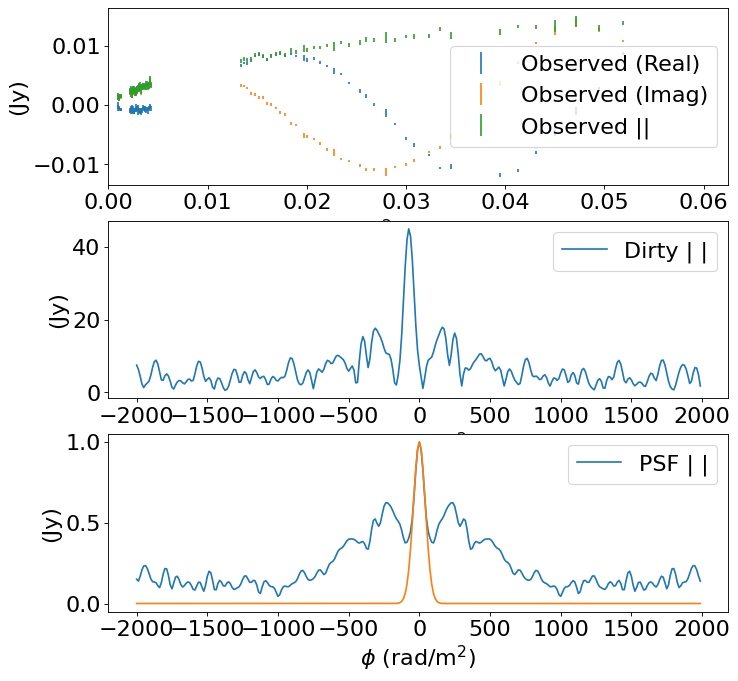

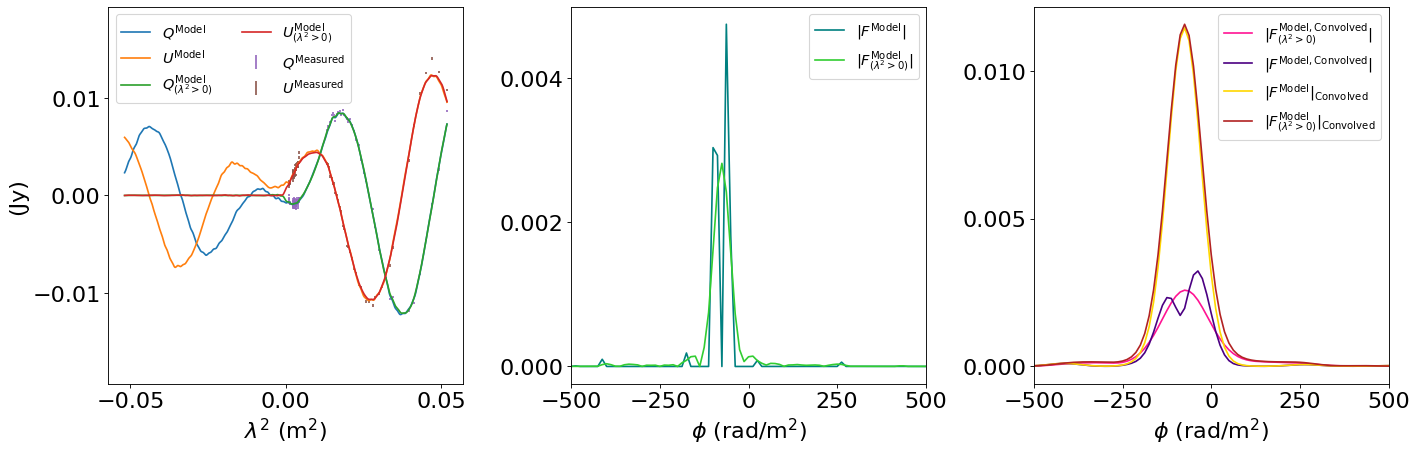

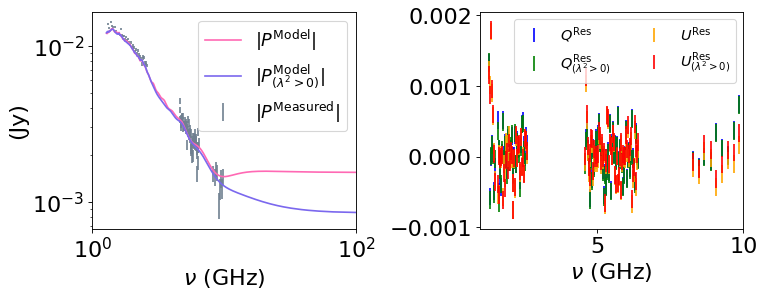

In [45]:
source = sources[13]
print(source)
sig_factor = 1/np.sqrt(2)
rm_max = 2000
rm_min = -2000
beta1, beta2 = 1e-2, 1e-2
test_source(source, sig_factor, rm_min, rm_max, beta1, beta2)

b'lmc_c15'
2021-09-09 14:33:39,341 - Faraday Dreams - INFO - φ resolution 31.374341931297003 rad/m^2.
2021-09-09 14:33:39,342 - Faraday Dreams - INFO - φ max range is 265073.40082525415 rad/m^2.
2021-09-09 14:33:39,342 - Faraday Dreams - INFO - φ min range is 668.9512150992091 rad/m^2.
2021-09-09 14:33:39,367 - Optimus Primal - INFO - Starting Power method
2021-09-09 14:33:39,367 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2021-09-09 14:33:39,368 - Optimus Primal - INFO - [Power Method] Converged with norm= 1833.7038496967834, iter = 4, tol = 7.933964662179952e-06
2021-09-09 14:33:39,369 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 1 levels
2021-09-09 14:33:39,370 - Faraday Dreams - INFO - Using an estimated noise level of 0.00039659091271460056 (weighted image units, i.e. Jy/Beam)
2021-09-09 14:33:39,370 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2021-09-09 14:33:39,371 - Optimus Primal - INFO - Running Forwar

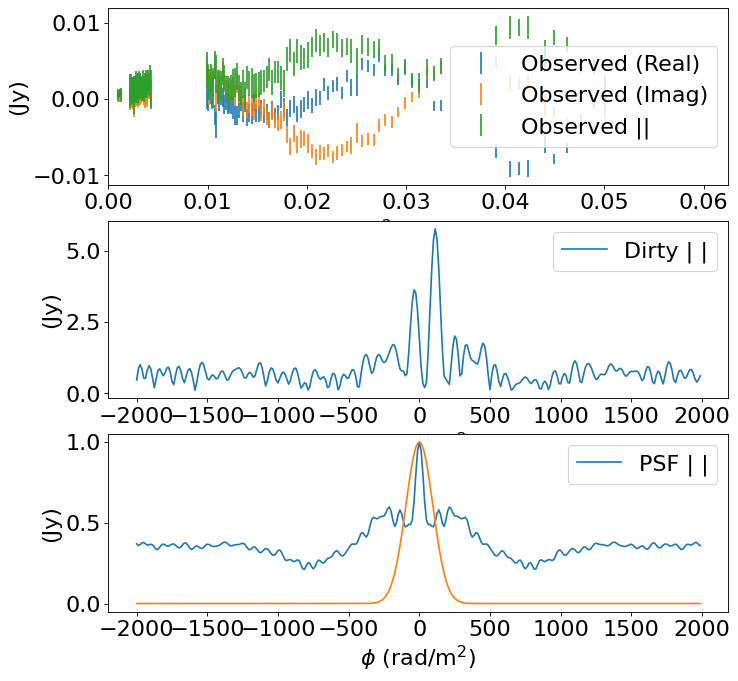

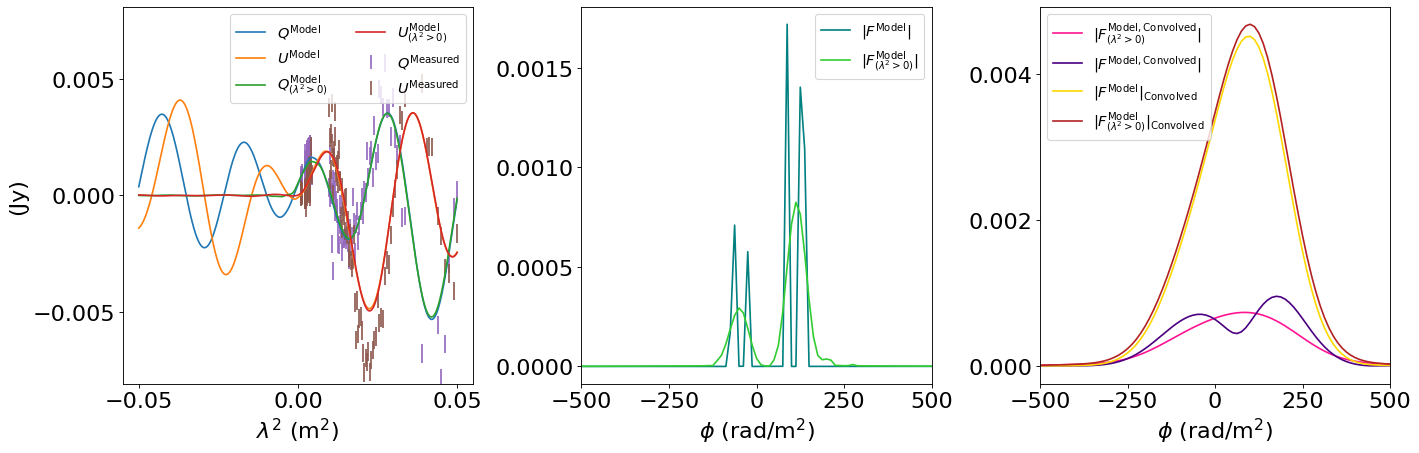

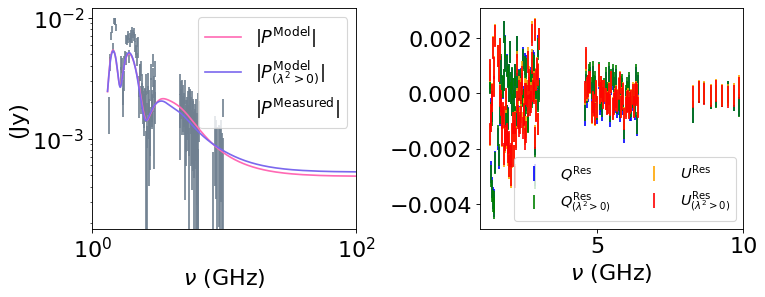

In [46]:
source = sources[31]
print(source)
sig_factor = 1/np.sqrt(2)
rm_max = 1000
rm_min = -1000
beta1, beta2 = 1e-2, 1e-2
test_source(source, sig_factor, rm_min, rm_max, beta1, beta2)